In [1]:
import pandas as pd
data = pd.read_csv("/content/SalaryData_Test.csv",encoding = "ISO-8859-1")

In [2]:
data.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [3]:
data.isnull().sum()

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


# Data Cleaning

In [5]:
import re #regular expression
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+"," ",text)
    text = re.sub('[‘’“”…]', '', text)
    return text

clean = lambda x: clean_text(x)


In [8]:
data['race'] = data.race.apply(clean)
data.race

0                    black
1                    white
2                    white
3                    black
4                    white
               ...        
15055                white
15056                white
15057                white
15058     asianpacislander
15059                white
Name: race, Length: 15060, dtype: object

In [9]:
#Word frequency
freq = pd.Series(' '.join(data['race']).split()).value_counts()[:20] # for top 20
freq

white               12970
black                1411
asianpacislander      408
amerindianeskimo      149
other                 122
dtype: int64

In [12]:
#removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['race'] = data['race'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
#word frequency after removal of stopwords
freq_Sw = pd.Series(' '.join(data['race']).split()).value_counts()[:20] # for top 20
freq_Sw

white               12970
black                1411
asianpacislander      408
amerindianeskimo      149
dtype: int64

In [14]:
# count vectoriser tells the frequency of a word.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(min_df = 1, max_df = 0.9)
X = vectorizer.fit_transform(data["race"])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
#print(word_freq_df.sort('occurrences',ascending = False).head())

In [15]:
word_freq_df.head(30)

,term,occurrences,frequency
0,amerindianeskimo,149,0.009975
1,asianpacislander,408,0.027313
2,black,1411,0.094457
3,white,12970,0.868255


In [16]:
#TFIDF - Term frequency inverse Document Frequencyt
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000, max_df = 0.5, smooth_idf=True) #keep top 1000 words
doc_vec = vectorizer.fit_transform(data["race"])
names_features = vectorizer.get_feature_names()
dense = doc_vec.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns = names_features)

In [17]:
df

,amerindianeskimo,asianpacislander,black
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0
...,...,...,...
15055,0.0,0.0,0.0
15056,0.0,0.0,0.0
15057,0.0,0.0,0.0
15058,0.0,1.0,0.0


# N-gram

In [18]:
#Bi-gram
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  #for tri-gram, put ngram_range=(3,3)
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [20]:
top2_words = get_top_n2_words(data["relationship"], n=200) #top 200
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df.head()

,Bi-gram,Freq
0,not in,3976
1,in family,3976
2,own child,2160
3,other relative,460


[Text(0, 0, 'not in'),
 Text(0, 0, 'in family'),
 Text(0, 0, 'own child'),
 Text(0, 0, 'other relative')]

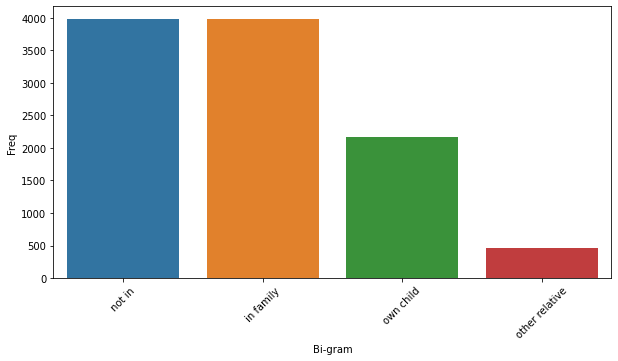

In [21]:
#Bi-gram plot
import matplotlib.pyplot as plt
import seaborn as sns
top20_bigram = top2_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top20_bigram["Bi-gram"],y=top20_bigram["Freq"])
plot.set_xticklabels(rotation=45,labels = top20_bigram["Bi-gram"])

In [22]:
#Tri-gram
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


In [23]:
top3_words = get_top_n3_words(data["relationship"], n=200)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]

In [24]:
top3_df

,Tri-gram,Freq
0,not in family,3976


[Text(0, 0, 'not in family')]

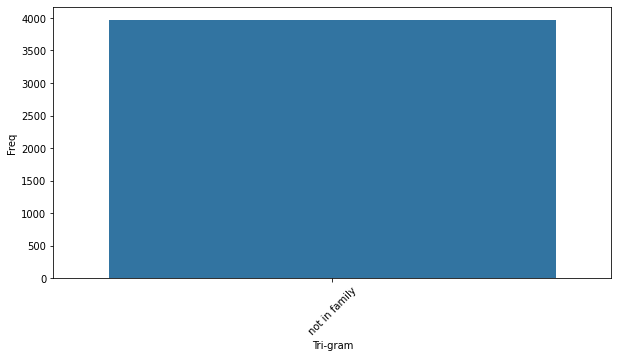

In [25]:
#Tri-gram plot
import seaborn as sns
top20_trigram = top3_df.iloc[0:20,:]
fig = plt.figure(figsize = (10, 5))
plot=sns.barplot(x=top20_trigram["Tri-gram"],y=top20_trigram["Freq"])
plot.set_xticklabels(rotation=45,labels = top20_trigram["Tri-gram"])

# WordCloud

In [29]:
string_Total = " ".join(data["relationship"])

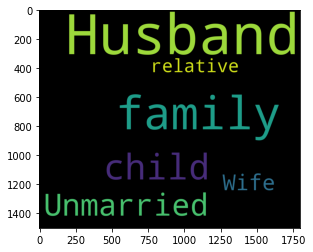

In [30]:
#wordcloud for entire corpus
from wordcloud import WordCloud
wordcloud_stw = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500
                ).generate(string_Total)
plt.imshow(wordcloud_stw)

# Applying naive bayes for classification

In [31]:
data.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,white,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,white,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,white,Male,0,0,30,United-States,<=50K


In [32]:
def split_into_words(i):
    return (i.split(" "))


In [36]:
from sklearn.model_selection import train_test_split

email_train,email_test = train_test_split(data,test_size=0.3)

In [37]:
email_test

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
4524,41,Private,HS-grad,9,Divorced,Sales,Unmarried,white,Female,0,0,40,United-States,<=50K
4789,18,Private,HS-grad,9,Never-married,Other-service,Not-in-family,white,Male,0,0,20,United-States,<=50K
9693,19,Private,Some-college,10,Never-married,Adm-clerical,Own-child,white,Female,0,0,15,United-States,<=50K
7888,46,Private,Masters,14,Never-married,Exec-managerial,Unmarried,white,Male,0,0,40,United-States,<=50K
11176,30,Local-gov,Bachelors,13,Never-married,Tech-support,Not-in-family,white,Male,3325,0,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12277,25,Private,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,black,Male,0,0,36,United-States,<=50K
282,24,Private,Bachelors,13,Never-married,Adm-clerical,Own-child,white,Male,0,0,40,United-States,<=50K
2893,35,Private,10th,6,Married-civ-spouse,Craft-repair,Husband,white,Male,0,0,40,United-States,<=50K
5611,48,Private,HS-grad,9,Never-married,Craft-repair,Own-child,white,Male,0,0,40,United-States,<=50K


In [40]:
# Preparing email texts into word count matrix format 
emails_bow = CountVectorizer(analyzer=split_into_words).fit(data.race)

# ["mailing","body","texting"]
# ["mailing","awesome","good"]

# ["mailing","body","texting","good","awesome"]



#        "mailing" "body" "texting" "good" "awesome"
#  0          1        1       1        0       0
 
#  1          1        0        0       1       1    



In [42]:
# For all messages
all_emails_matrix = emails_bow.transform(data.race)
all_emails_matrix.shape 

(15060, 5)

In [44]:
# For training messages
train_emails_matrix = emails_bow.transform(email_train.race)
train_emails_matrix.shape # (3891,8175)

# For testing messages
test_emails_matrix = emails_bow.transform(email_test.race)
test_emails_matrix.shape # (1668,8175)

(4518, 5)

In [47]:
####### Without TFIDF matrices ########################
# Preparing a naive bayes model on training data set 

from sklearn.naive_bayes import MultinomialNB as MB
from sklearn.naive_bayes import GaussianNB as GB

# Multinomial Naive Bayes
classifier_mb = MB()
classifier_mb.fit(train_emails_matrix,email_train.race)
train_pred_m = classifier_mb.predict(train_emails_matrix)
accuracy_train_m = np.mean(train_pred_m==email_train.native) # 98%

test_pred_m = classifier_mb.predict(test_emails_matrix)
accuracy_test_m = np.mean(test_pred_m==email_test.native) # 96%



In [48]:
# Gaussian Naive Bayes 
classifier_gb = GB()
classifier_gb.fit(train_emails_matrix.toarray(),email_train.native.values) # we need to convert tfidf into array format which is compatible for gaussian naive bayes
train_pred_g = classifier_gb.predict(train_emails_matrix.toarray())
accuracy_train_g = np.mean(train_pred_g==email_train.native) # 95%

test_pred_g = classifier_gb.predict(test_emails_matrix.toarray())
accuracy_test_g = np.mean(test_pred_g==email_test.native) # 8%

# Using TFIDF

In [49]:
from sklearn.feature_extraction.text import TfidfTransformer

# Learning Term weighting and normalizing on entire emails
tfidf_transformer = TfidfTransformer().fit(all_emails_matrix)

# Preparing TFIDF for train emails
train_tfidf = tfidf_transformer.transform(train_emails_matrix)

train_tfidf.shape # (3891, 6661)

# Preparing TFIDF for test emails
test_tfidf = tfidf_transformer.transform(test_emails_matrix)

test_tfidf.shape #  (1668, 6661)



(4518, 5)

In [51]:
# Preparing a naive bayes model on training data set 

from sklearn.naive_bayes import MultinomialNB as MB
from sklearn.naive_bayes import GaussianNB as GB

# Multinomial Naive Bayes
classifier_mb = MB()
classifier_mb.fit(train_tfidf,email_train.native)
train_pred_m = classifier_mb.predict(train_tfidf)
accuracy_train_m = np.mean(train_pred_m==email_train.native) # 96%

test_pred_m = classifier_mb.predict(test_tfidf)
accuracy_test_m = np.mean(test_pred_m==email_test.native) # 96%

 


In [52]:
accuracy_train_m

0.915575792069816

In [53]:
# Gaussian Naive Bayes 
classifier_gb = GB()
classifier_gb.fit(train_tfidf.toarray(),email_train.native.values) # we need to convert tfidf into array format which is compatible for gaussian naive bayes
train_pred_g = classifier_gb.predict(train_tfidf.toarray())
accuracy_train_g = np.mean(train_pred_g==email_train.native) # 95%
test_pred_g = classifier_gb.predict(test_tfidf.toarray())
accuracy_test_g = np.mean(test_pred_g==email_test.native) # 88%

# inplace of tfidf we can also use train_emails_matrix and test_emails_matrix instead of term inverse document frequency matrix

In [54]:
accuracy_test_g

0.01438689685701638